In [1]:
from alignment import HSP, HSPVertex, Alignment, Transcript

1. Examples of HSP usage: init, other methods
2. Explanation of HSPVertex
3. Alignment: parsing, making, methods
4. Transcript: connection to an alignment, methods
5. Real-world case: blast (sequence example fetching, output formatting, plotting)

## HSP

HSP is a high-scoring pair in BLAST notation. It represents an ungapped alignment block of two sequences (i.e. no gaps in both sequences at the same time). Simple `HSP` instance here can be made from coordinates of that block in both sequences and an alignment raw score.

In [2]:
HSP(qstart=10, qend=20, sstart=15, send=27, score=20)

HSP(10, 20, 15, 27, 20, **{})

Additional information can be provided via `kwargs`.

In [3]:
HSP(qstart=10, qend=20, sstart=15, send=27, score=20, gaps=5, gapopens=2, mismatch=7)

HSP(10, 20, 15, 27, 20, **{'gaps': 5, 'gapopens': 2, 'mismatch': 7})

### HSP attributes

In [4]:
hsp = HSP(qstart=10, qend=20, sstart=15, send=27, score=20, gaps=5, gapopens=2, mismatch=7)

Arbitrary initiative attributes can be accessed.

In [5]:
hsp.qstart, hsp.qend, hsp.sstart, hsp.send, hsp.score

(10, 20, 15, 27, 20)

`kwargs` are stored in `kwargs` dict.

In [6]:
hsp.kwargs

{'gaps': 5, 'gapopens': 2, 'mismatch': 7}

Both sequences have strandness in HSP: + or -. Query sequence is always +-stranded. If subject end is greater, than subject start, then subject is +-stranded, --stranded otherwise. Sequence orientations are notated as `qstrand` and `sstrand` and are `True`, if +, `False` otherwise.

In [7]:
hsp.qstrand, hsp.sstrand

(True, True)

HSP has orientation: if both query and subject strands are +, it is direct, reverse otherwise.

In [8]:
hsp.orientation

'direct'

### HSP representation

HSP representation returns a string that can be used to restore original object.

In [9]:
repr(hsp)

"HSP(10, 20, 15, 27, 20, **{'gaps': 5, 'gapopens': 2, 'mismatch': 7})"

String representation of HSP provides verbal representation of HSP with query and subject coordinates, score and orientation.

In [10]:
str(hsp)

'q 10:20 s 15:27 score 20 direct'

### HSP methods

#### Precedence

Precedence is occured when two HSPs are oriented identically and do not intersect on both query and subject sequences. Take `hsp1` and `hsp2` for example. `hsp1` precedes `hsp2` in query sequence, if end of `hsp1` is lesser than start of `hsp2`. In subject sequence in case of direct HSPs orientations the rule the same. If orientations are reverse, the rule is opposite. If orientations are inconsistent, precedence cannot be defined. Only if `hsp1` precedes `hsp2` on both query and subject sequences, `hsp1` precedes `hsp2`.

In [11]:
hsp1 = HSP(qstart=10, qend=20, sstart=15, send=27, score=20)
hsp2 = HSP(qstart=22, qend=25, sstart=30, send=36, score=10)
hsp1.precede(hsp2)

True

The method does not distinguish between succeeding and intersecting.

In [12]:
hsp3 = HSP(qstart=17, qend=25, sstart=30, send=36, score=11)

In [13]:
hsp1.precede(hsp3), hsp2.precede(hsp1)

(False, False)

The exception is thrown in case of inconsistent orientations.

In [14]:
hsp4 = HSP(qstart=22, qend=25, sstart=36, send=30, score=10)
hsp1.precede(hsp4)

ValueError: HSPs have inconsistent orientations: direct for q 10:20 s 15:27 score 20 direct and reverse for q 22:25 s 36:30 score 10 reverse.

#### Copy

HSP can be copied to another instance.

In [15]:
hsp.copy()

HSP(10, 20, 15, 27, 20, **{'gaps': 5, 'gapopens': 2, 'mismatch': 7})

#### Interplay with dictionary representation

HSP can be converted to dictionary representation. It is useful in case of saving to json. Full state of HSP is dumped so user can operate with HSPs both as python objects or as regular dictionaries.

In [16]:
hsp.to_dict()

{'qstart': 10,
 'qend': 20,
 'sstart': 15,
 'send': 27,
 'score': 20,
 'kwargs': {'gaps': 5, 'gapopens': 2, 'mismatch': 7},
 'qstrand': True,
 'sstrand': True,
 'orientation': 'direct'}

HSP can be restored from dictionary representation.

In [17]:
HSP.from_dict(hsp.to_dict())

HSP(10, 20, 15, 27, 20, **{'gaps': 5, 'gapopens': 2, 'mismatch': 7})

#### Distance

Distance between two HSPs of same orientation is calculated as sum of distances in query and subject sequence multiplied by gap extension penalty added with gap opening penalty and subtracted with the score of the following HSP. In case none HSP precedes the other one (overlap or different, non-sequential placement) the distance is set to infinity.


In [18]:
hsp1.distance(hsp2)

5

Distance is symmetric.

In [19]:
hsp2.distance(hsp1)

5

Infinity distance in case of overlap is required for downstream graph operations.

In [20]:
hsp1.distance(hsp3)

inf

#### Boundary processing

HSP can be pruned on query or subject sequence from left or right (4 combinations). Its raw score is decreased proportionally. If HSP is pruned on query sequence, its coordinates on subject sequence are recalculated considering HSP as a straight in query-subject coordinates.

In [21]:
print(hsp1)

q 10:20 s 15:27 score 20 direct


In [22]:
pruned_hsp1 = HSP._process_boundary(hsp1, point=12, type_='qleft', inplace=False)

In [23]:
pruned_hsp2 = HSP._process_boundary(hsp1, point=12, type_='qright', inplace=False)

In [24]:
pruned_hsp3 = HSP._process_boundary(hsp1, point=17, type_='sleft', inplace=False)

In [25]:
pruned_hsp4 = HSP._process_boundary(hsp1, point=17, type_='sright', inplace=False)

Changing `type_` from left to right changes coordinates and score.

In [26]:
print(pruned_hsp1, pruned_hsp2, sep='\n')

q 12:20 s 17:27 score 16.0 direct
q 10:12 s 15:17 score 4.0 direct


In [27]:
print(pruned_hsp3, pruned_hsp4, sep='\n')

q 12:20 s 17:27 score 16.666666666666668 direct
q 10:12 s 15:17 score 3.333333333333333 direct


Chosing relative points for qleft (12 on query) and sleft (17 on subject) results in same coordinates, but in different score because score decrease is calculated regarding the sequence on which boundary is set.

In [28]:
print(pruned_hsp1, pruned_hsp3, sep='\n')

q 12:20 s 17:27 score 16.0 direct
q 12:20 s 17:27 score 16.666666666666668 direct


In [29]:
print(pruned_hsp2, pruned_hsp4, sep='\n')

q 10:12 s 15:17 score 4.0 direct
q 10:12 s 15:17 score 3.333333333333333 direct


Overall, boundary processing heavily relies on geometric representaion of HSP as a section in query sequence - subject sequence plane.

## HSPVertex

It's a successor of `HSP` class for handling graph operations. Contains certain attributes: list of successors, best score and best previous vertex.

## Alignment

Represents a BLAST alignment of two sequences (NOT an alignment of a sequence against a database!). Contains a list of HSPs and other additional information. Allows to read BLAST alignment from file produced with `-outfmt '7 std score'`, plot an alignment map, read from and write to dictionary representation (hence, JSON) and find best transcripts based on some strategies.

### Construction from list of HSPs

An `Alignment` instance can be initialized from the list of HSPs.

In [30]:
hsp_data = [[1, 10, 2, 11, 10],
            [8, 10, 47, 55, 15],
            [8, 15, 5, 12, 10],
            [20, 25, 13, 18, 15],
            [27, 30, 22, 24, 10],
            [35, 40, 30, 36, 15],
            [38, 45, 36, 47, 10],
            [42, 48, 40, 47, 15],
            [50, 55, 50, 55, 10],
            [54, 70, 66, 72, 15],
           ]

In [31]:
vertices = [HSPVertex(*i) for i in hsp_data]

In [32]:
alignment = Alignment(vertices)

User can access list of all HSPs.

In [33]:
alignment._all_HSPs

[HSPVertex(1, 10, 2, 11, 10, **{}),
 HSPVertex(8, 10, 47, 55, 15, **{}),
 HSPVertex(8, 15, 5, 12, 10, **{}),
 HSPVertex(20, 25, 13, 18, 15, **{}),
 HSPVertex(27, 30, 22, 24, 10, **{}),
 HSPVertex(35, 40, 30, 36, 15, **{}),
 HSPVertex(38, 45, 36, 47, 10, **{}),
 HSPVertex(42, 48, 40, 47, 15, **{}),
 HSPVertex(50, 55, 50, 55, 10, **{}),
 HSPVertex(54, 70, 66, 72, 15, **{})]

If query and subject sequences lengths are not passed to a constructor, lengths are calculated regarding HSP coordinates.

In [34]:
alignment.qlen, alignment.slen

(71, 73)

Alignment can be viewed as a plot in query sequence - subject sequence plane with each section representing one HSP.

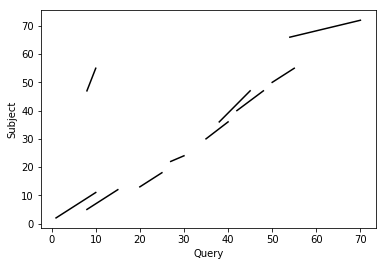

In [35]:
alignment.plot_alignment()

### Alignment representations

In [36]:
alignment

Alignment([HSPVertex(1, 10, 2, 11, 10, **{}), HSPVertex(8, 10, 47, 55, 15, **{}), HSPVertex(8, 15, 5, 12, 10, **{}), HSPVertex(20, 25, 13, 18, 15, **{}), HSPVertex(27, 30, 22, 24, 10, **{}), HSPVertex(35, 40, 30, 36, 15, **{}), HSPVertex(38, 45, 36, 47, 10, **{}), HSPVertex(42, 48, 40, 47, 15, **{}), HSPVertex(50, 55, 50, 55, 10, **{}), HSPVertex(54, 70, 66, 72, 15, **{})], 71, 73)

In [37]:
print(alignment)

Alignment of 71 and 73
q 1:10 s 2:11 score 10 direct
	
q 8:10 s 47:55 score 15 direct
	
q 8:15 s 5:12 score 10 direct
	
q 20:25 s 13:18 score 15 direct
	
q 27:30 s 22:24 score 10 direct
	
q 35:40 s 30:36 score 15 direct
	
q 38:45 s 36:47 score 10 direct
	
q 42:48 s 40:47 score 15 direct
	
q 50:55 s 50:55 score 10 direct
	
q 54:70 s 66:72 score 15 direct
	


### Filtering by score

Alignment HSPs can be filtered by score. Actual HSPs are stored in `.HSPs` and only them are taken into account for other operations. All HSPs are stored in `._all_HSPs`.

In [38]:
alignment.HSPs

[HSPVertex(1, 10, 2, 11, 10, **{}),
 HSPVertex(8, 10, 47, 55, 15, **{}),
 HSPVertex(8, 15, 5, 12, 10, **{}),
 HSPVertex(20, 25, 13, 18, 15, **{}),
 HSPVertex(27, 30, 22, 24, 10, **{}),
 HSPVertex(35, 40, 30, 36, 15, **{}),
 HSPVertex(38, 45, 36, 47, 10, **{}),
 HSPVertex(42, 48, 40, 47, 15, **{}),
 HSPVertex(50, 55, 50, 55, 10, **{}),
 HSPVertex(54, 70, 66, 72, 15, **{})]

In [39]:
alignment._all_HSPs

[HSPVertex(1, 10, 2, 11, 10, **{}),
 HSPVertex(8, 10, 47, 55, 15, **{}),
 HSPVertex(8, 15, 5, 12, 10, **{}),
 HSPVertex(20, 25, 13, 18, 15, **{}),
 HSPVertex(27, 30, 22, 24, 10, **{}),
 HSPVertex(35, 40, 30, 36, 15, **{}),
 HSPVertex(38, 45, 36, 47, 10, **{}),
 HSPVertex(42, 48, 40, 47, 15, **{}),
 HSPVertex(50, 55, 50, 55, 10, **{}),
 HSPVertex(54, 70, 66, 72, 15, **{})]

In [40]:
alignment.filter_by_score(10)

In [41]:
alignment.HSPs

[HSPVertex(8, 10, 47, 55, 15, **{}),
 HSPVertex(20, 25, 13, 18, 15, **{}),
 HSPVertex(35, 40, 30, 36, 15, **{}),
 HSPVertex(42, 48, 40, 47, 15, **{}),
 HSPVertex(54, 70, 66, 72, 15, **{})]

In [42]:
alignment._all_HSPs

[HSPVertex(1, 10, 2, 11, 10, **{}),
 HSPVertex(8, 10, 47, 55, 15, **{}),
 HSPVertex(8, 15, 5, 12, 10, **{}),
 HSPVertex(20, 25, 13, 18, 15, **{}),
 HSPVertex(27, 30, 22, 24, 10, **{}),
 HSPVertex(35, 40, 30, 36, 15, **{}),
 HSPVertex(38, 45, 36, 47, 10, **{}),
 HSPVertex(42, 48, 40, 47, 15, **{}),
 HSPVertex(50, 55, 50, 55, 10, **{}),
 HSPVertex(54, 70, 66, 72, 15, **{})]

Dropped HSPs are plotted grey.

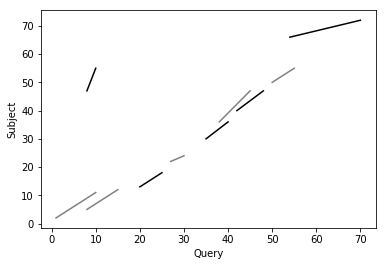

In [43]:
alignment.plot_alignment()

Filtering state can be accessed from `.filtered` attribute.

In [44]:
alignment.filtered

True

Filter can be reset.

In [45]:
alignment.reset_filter_by_score()

In [46]:
alignment.HSPs

[HSPVertex(1, 10, 2, 11, 10, **{}),
 HSPVertex(8, 10, 47, 55, 15, **{}),
 HSPVertex(8, 15, 5, 12, 10, **{}),
 HSPVertex(20, 25, 13, 18, 15, **{}),
 HSPVertex(27, 30, 22, 24, 10, **{}),
 HSPVertex(35, 40, 30, 36, 15, **{}),
 HSPVertex(38, 45, 36, 47, 10, **{}),
 HSPVertex(42, 48, 40, 47, 15, **{}),
 HSPVertex(50, 55, 50, 55, 10, **{}),
 HSPVertex(54, 70, 66, 72, 15, **{})]

In [47]:
alignment.filtered

False

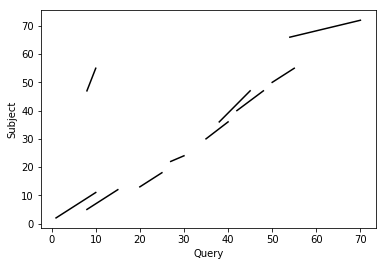

In [48]:
alignment.plot_alignment()

### Changing coordinates

Any method that changes HSP coordinates returns new `Alignment` instance.

First, one can decide to translate alignment coordinates to genomic ones. To do that, one should provide genomic coordinates of alignment zeros.

In [49]:
genomic_alignment = alignment.set_zero(qzero=10000, szero=15000)

In [50]:
print(genomic_alignment)

Alignment of 10071 and 15073
q 10001:10010 s 15002:15011 score 10 direct
q 10008:10010 s 15047:15055 score 15 direct
q 10008:10015 s 15005:15012 score 10 direct
q 10020:10025 s 15013:15018 score 15 direct
q 10027:10030 s 15022:15024 score 10 direct
q 10035:10040 s 15030:15036 score 15 direct
q 10038:10045 s 15036:15047 score 10 direct
q 10042:10048 s 15040:15047 score 15 direct
q 10050:10055 s 15050:15055 score 10 direct
q 10054:10070 s 15066:15072 score 15 direct


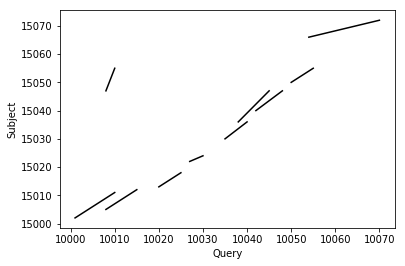

In [51]:
genomic_alignment.plot_alignment()

Second, one can decide to select only those HSPs that fit into certain section of query and/or subject genome.

In [52]:
cut_alignment = alignment.cut_coordinates(qleft=10, qright=60, sleft=7, sright=71)

HSPs are filtered out or cut with `HSP._process_boundary`.

In [53]:
print(cut_alignment)

Alignment of 71 and 73
q 10:10 s 11:11 score 0.0 direct
q 10:10 s 55:55 score 0.0 direct
q 10:15 s 7:12 score 7.142857142857143 direct
q 20:25 s 13:18 score 15 direct
q 27:30 s 22:24 score 10 direct
q 35:40 s 30:36 score 15 direct
q 38:45 s 36:47 score 10 direct
q 42:48 s 40:47 score 15 direct
q 50:55 s 50:55 score 10 direct
q 54:60 s 66:68 score 5.625 direct


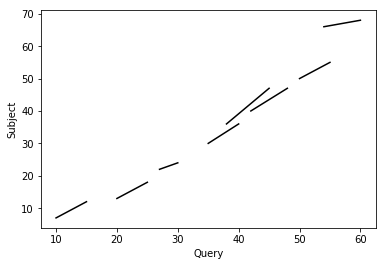

In [54]:
cut_alignment.plot_alignment()

### Transcripts

There are two modes for transcript assembly from an `Alignment` instance. The first is to get all transcripts, i.e. all possible transcripts in both orientations from non-overlapping HSPs with the greatest possible number of HSPs. It means that transcripts are build from sequence of HSPs (defined by `HSP.precede` method). If two or more HSPs overlap each other, new transcripts are branched to avoid HSP overlap.

In [55]:
for orientation, transcripts in alignment.get_all_transcripts().items():
    print(orientation, len(transcripts))

direct 9
reverse 0


A dictionary is returned with lists of `Transcript` instances for each orientation.

In [56]:
alignment.get_all_transcripts()

{'direct': [Transcript([HSPVertex(8, 10, 47, 55, 15, **{}), HSPVertex(54, 70, 66, 72, 15, **{})]),
  Transcript([HSPVertex(8, 15, 5, 12, 10, **{}), HSPVertex(20, 25, 13, 18, 15, **{}), HSPVertex(27, 30, 22, 24, 10, **{}), HSPVertex(38, 45, 36, 47, 10, **{}), HSPVertex(54, 70, 66, 72, 15, **{})]),
  Transcript([HSPVertex(8, 15, 5, 12, 10, **{}), HSPVertex(20, 25, 13, 18, 15, **{}), HSPVertex(27, 30, 22, 24, 10, **{}), HSPVertex(38, 45, 36, 47, 10, **{}), HSPVertex(50, 55, 50, 55, 10, **{})]),
  Transcript([HSPVertex(8, 15, 5, 12, 10, **{}), HSPVertex(20, 25, 13, 18, 15, **{}), HSPVertex(27, 30, 22, 24, 10, **{}), HSPVertex(35, 40, 30, 36, 15, **{}), HSPVertex(42, 48, 40, 47, 15, **{}), HSPVertex(54, 70, 66, 72, 15, **{})]),
  Transcript([HSPVertex(8, 15, 5, 12, 10, **{}), HSPVertex(20, 25, 13, 18, 15, **{}), HSPVertex(27, 30, 22, 24, 10, **{}), HSPVertex(35, 40, 30, 36, 15, **{}), HSPVertex(42, 48, 40, 47, 15, **{}), HSPVertex(50, 55, 50, 55, 10, **{})]),
  Transcript([HSPVertex(1, 10, 

The second mode is to get best transcript for each orientation. Transcript is assembled in a BLAT-like way. Each HSP represents a graph vertex. Sequential HSPs are connected with edges which weigts are gap penalties (positive) minus following HSP score. The transcript with the least penalty (i.e. the greatest score) is found with dynamic programming algorithm.

In [57]:
alignment.get_best_transcripts()

{'direct': Transcript([HSPVertex(1, 10, 2, 11, 10, **{}), HSPVertex(20, 25, 13, 18, 15, **{}), HSPVertex(27, 30, 22, 24, 10, **{}), HSPVertex(35, 40, 30, 36, 15, **{}), HSPVertex(42, 48, 40, 47, 15, **{}), HSPVertex(54, 70, 66, 72, 15, **{})]),
 'reverse': Transcript([])}

The method returns a dictionary with one transcript for each orientation.

### Dictionary interplay

Alignment can be put to dictionary. Its keys are: HSPs (`._all_HSPs`), qlen, slen, filtered_HSPs (`.HSPs`), filtered.

In [58]:
alignment.to_dict()

{'HSPs': [{'qstart': 1,
   'qend': 10,
   'sstart': 2,
   'send': 11,
   'score': 10,
   'kwargs': {},
   'qstrand': True,
   'sstrand': True,
   'orientation': 'direct',
   'next_vertices': [[HSPVertex(20, 25, 13, 18, 15, **{}), 14]],
   'total_score': 1,
   'best_prev': HSPVertex(0, 0, 0, 0, 0, **{})},
  {'qstart': 8,
   'qend': 10,
   'sstart': 47,
   'send': 55,
   'score': 15,
   'kwargs': {},
   'qstrand': True,
   'sstrand': True,
   'orientation': 'direct',
   'next_vertices': [[HSPVertex(54, 70, 66, 72, 15, **{}), 100]],
   'total_score': 100,
   'best_prev': HSPVertex(0, 0, 0, 0, 0, **{})},
  {'qstart': 8,
   'qend': 15,
   'sstart': 5,
   'send': 12,
   'score': 10,
   'kwargs': {},
   'qstrand': True,
   'sstrand': True,
   'orientation': 'direct',
   'next_vertices': [[HSPVertex(20, 25, 13, 18, 15, **{}), 2]],
   'total_score': 21,
   'best_prev': HSPVertex(0, 0, 0, 0, 0, **{})},
  {'qstart': 20,
   'qend': 25,
   'sstart': 13,
   'send': 18,
   'score': 15,
   'kwargs': {

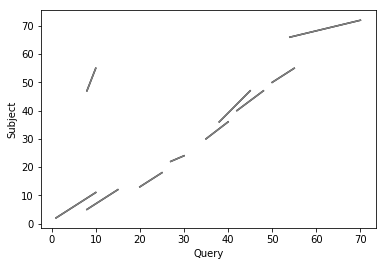

In [59]:
Alignment.from_dict(alignment.to_dict()).plot_alignment()

Filtering state can be saved to dictionary.

In [60]:
alignment.filter_by_score(10)

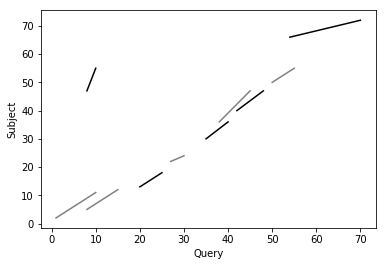

In [61]:
alignment.plot_alignment()

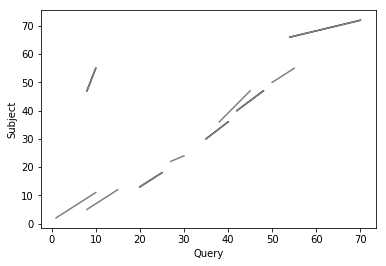

In [62]:
Alignment.from_dict(alignment.to_dict()).plot_alignment()

### Reading from blast output

Let's align human and mouse hotair genes with blastn to find conservative regions.

In [63]:
%%bash
blastn -query hotair_human_gene.fasta -subject hotair_mouse_gene.fasta -task blastn -outfmt '7 std score' -word_size 6 -perc_identity 50 > sample_alignment.tsv

An output format `7 std score` is required for accurate processing.

In [64]:
%%bash
cat sample_alignment.tsv

# BLASTN 2.7.1+
# Query: NC_000012.12:c53974956-53962308 Homo sapiens chromosome 12, GRCh38.p13 Primary Assembly
# Database: User specified sequence set (Input: hotair_mouse_gene.fasta)
# Fields: query acc.ver, subject acc.ver, % identity, alignment length, mismatches, gap opens, q. start, q. end, s. start, s. end, evalue, bit score, score
# 43 hits found
NC_000012.12:c53974956-53962308	NC_000081.6:c102947946-102944062	74.820	1247	185	42	10305	11496	1587	2759	0.0	760	842
NC_000012.12:c53974956-53962308	NC_000081.6:c102947946-102944062	68.369	1606	313	50	8518	10084	19	1468	1.25e-160	556	616
NC_000012.12:c53974956-53962308	NC_000081.6:c102947946-102944062	72.381	105	28	1	11934	12038	3112	3215	1.04e-09	55.4	60
NC_000012.12:c53974956-53962308	NC_000081.6:c102947946-102944062	66.138	189	50	6	12408	12594	3658	3834	7.97e-05	39.2	42
NC_000012.12:c53974956-53962308	NC_000081.6:c102947946-102944062	75.510	49	12	0	11633	11681	2851	2899	0.001	35.6	38
NC_000012.12:c53974956-53962308	NC_000081.6:c10

In [65]:
with open("sample_alignment.tsv", 'r') as infile:
    blast_alignment = Alignment.from_file(infile)

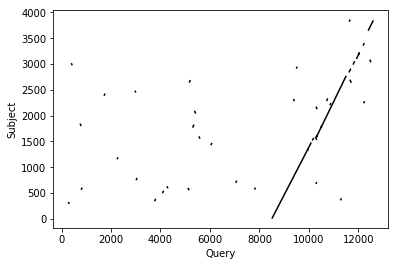

In [66]:
blast_alignment.plot_alignment()

We can filter out noisy HSPs of random alignment and reconstruct mouse transcript based on conservative regions.

In [67]:
for hsp in blast_alignment._all_HSPs:
    print(hsp.score)

842
616
60
42
38
32
32
28
28
28
28
28
28
28
26
26
26
26
26
26
26
26
26
26
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24
24


In [68]:
blast_alignment.filter_by_score(30)

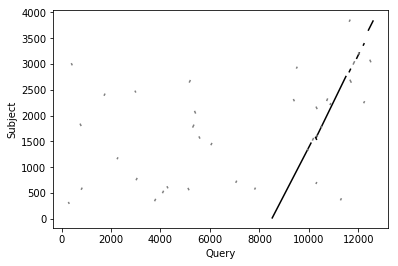

In [69]:
blast_alignment.plot_alignment()

In [70]:
best_transcript = blast_alignment.get_best_transcripts()['direct']

## Transcript

`Transcript` instance represents a transcript. It contains ordered list of HSPs, transcript score and a link to a relevant alignment.

In [71]:
best_transcript.HSPs

[HSPVertex(8518, 10084, 19, 1468, 616, **{'query acc.ver': 'NC_000012.12:c53974956-53962308', 'subject acc.ver': 'NC_000081.6:c102947946-102944062', '% identity': 68.369, 'alignment length': 1606, 'mismatches': 313, 'gap opens': 50, 'evalue': 1.25e-160, 'bit score': 556}),
 HSPVertex(10305, 11496, 1587, 2759, 842, **{'query acc.ver': 'NC_000012.12:c53974956-53962308', 'subject acc.ver': 'NC_000081.6:c102947946-102944062', '% identity': 74.82, 'alignment length': 1247, 'mismatches': 185, 'gap opens': 42, 'evalue': 0, 'bit score': 760}),
 HSPVertex(11633, 11681, 2851, 2899, 38, **{'query acc.ver': 'NC_000012.12:c53974956-53962308', 'subject acc.ver': 'NC_000081.6:c102947946-102944062', '% identity': 75.51, 'alignment length': 49, 'mismatches': 12, 'gap opens': 0, 'evalue': 0.001, 'bit score': 35.6}),
 HSPVertex(11934, 12038, 3112, 3215, 60, **{'query acc.ver': 'NC_000012.12:c53974956-53962308', 'subject acc.ver': 'NC_000081.6:c102947946-102944062', '% identity': 72.381, 'alignment length

In [72]:
best_transcript.score

-1991

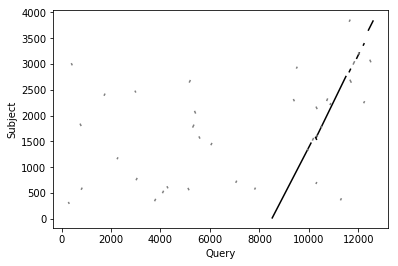

In [73]:
best_transcript.alignment.plot_alignment()

Transcript can be plotted.

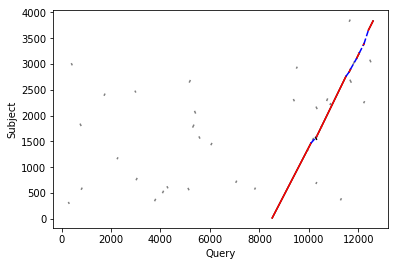

In [74]:
best_transcript.plot_transcript()

Red HSPs are HSPs belonging to transcript, grey HSPs are not, blue dashed lines indicate gaps.

In [75]:
print(best_transcript)

qstart	qend	sstart	send
8518	10084	19	1468
10305	11496	1587	2759
11633	11681	2851	2899
11934	12038	3112	3215
12204	12229	3368	3393
12408	12594	3658	3834


### Dictionary interplay

The `Transcript` instance can be transformed to dictionary containing list of HSPs, relative alignment and transcript score. HSPs and the alignment are also transformed to dictionaries.

In [76]:
best_transcript.to_dict().keys()

dict_keys(['HSPs', 'alignment', 'score'])

Transcript can be fully recovered from dictionary.

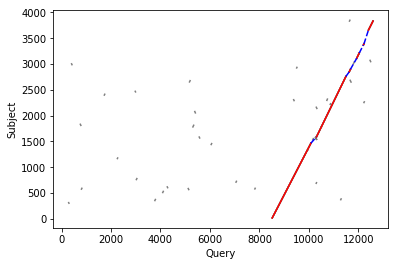

In [77]:
Transcript.from_dict(best_transcript.to_dict()).plot_transcript()